## Dependencies

In [7]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
import rosbag
import tf
import csv
from tqdm import tqdm
from cv_bridge import CvBridge, CvBridgeError
from std_msgs.msg import Header
from sensor_msgs.msg import Image
from geometry_msgs.msg import PoseWithCovarianceStamped

from generator import GenerateRosbag
from transformations import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def convert_4x4_matrix_robotics_to_cv(matrix):
    """
    Converts a 4x4 transformation matrix from robotics convention
    (X forward, Y left, Z up) to computer vision convention
    (X right, Y down, Z forward).
    
    Args:
    matrix (np.ndarray): A 4x4 transformation matrix.
    
    Returns:
    np.ndarray: The converted 4x4 transformation matrix.
    """
    # Rotation matrix to convert from robotics to computer vision convention
    R_conversion = np.array([
        [0,  1,  0],
        [1,  0,  0],
        [0,  0, -1]
    ])

    # Extract the 3x3 rotation part and the 3x1 translation part
    R_robotics = matrix[:3, :3]
    t_robotics = matrix[:3, 3]

    # Convert the rotation matrix
    R_cv = R_conversion @ R_robotics

    # Convert the translation vector
    t_cv = R_conversion @ t_robotics

    # Construct the new 4x4 transformation matrix
    matrix_cv = np.eye(4)
    matrix_cv[:3, :3] = R_cv
    matrix_cv[:3, 3] = t_cv

    return matrix_cv


def convert_4x4_matrix_cv_to_robotics(matrix):
    """
    Converts a 4x4 transformation matrix from computer vision convention
    (X right, Y down, Z forward) to robotics convention
    (X forward, Y left, Z up).
    
    Args:
    matrix (np.ndarray): A 4x4 transformation matrix.
    
    Returns:
    np.ndarray: The converted 4x4 transformation matrix.
    """
    # Inverse rotation matrix to convert from computer vision to robotics convention
    R_conversion = np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, -1]
    ])

    # Extract the 3x3 rotation part and the 3x1 translation part
    R_cv = matrix[:3, :3]
    t_cv = matrix[:3, 3]

    # Convert the rotation matrix
    R_robotics = R_conversion @ R_cv @ R_conversion.T

    # Convert the translation vector
    t_robotics = R_conversion @ t_cv

    # Construct the new 4x4 transformation matrix
    matrix_robotics = np.eye(4)
    matrix_robotics[:3, :3] = R_robotics
    matrix_robotics[:3, 3] = t_robotics

    return matrix_robotics

def rotateZ(matrix, degrees):
    theta = np.radians(degrees)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotation_matrix_z = np.array([
        [cos_theta, -sin_theta, 0, 0],
        [sin_theta, cos_theta, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return np.dot(rotation_matrix_z, matrix)


def intrinsics_from_ini_file(filename):
    parameters = {}
    
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                key, value = line.split()
                parameters[key] = float(value)
    
    fx = parameters.get('fx')
    fy = parameters.get('fy')
    cx = parameters.get('cx')
    cy = parameters.get('cy')
    
    return [fx, fy, cx, cy]

## Read data

In [9]:
scene_id = 86
v2016 = False # if you are using sceneNN version of 2021, set to False
dataset_path = r"/home/josematez/Datasets/scenenn/dataset"
dataset_path = dataset_path + "/{:03d}/".format(scene_id)

[544.47329, 544.47329, 320.0, 240.0]
5900 5902


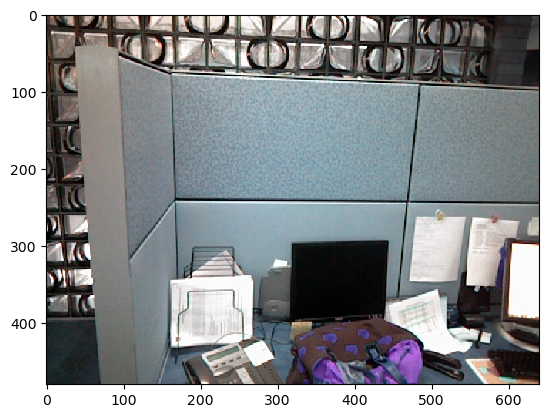

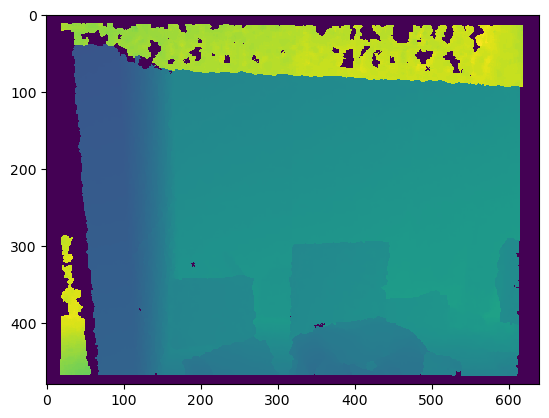

In [10]:
# Data info
n_data = len(os.listdir(dataset_path + "images/image/"))

# Depth, RGB, segmentation_img, colors.txt (wall class code), extrinsic.txt (poses), intrinsic.txt (poses), camera_number
#with open(dataset_path + "intrinsic/intrinsic_depth.txt", 'r') as file:
#    data = file.read()
#matrix_list = [list(map(float, row.split())) for row in data.strip().split('\n')]
#matrix_array = np.array(matrix_list)
intrinsics = intrinsics_from_ini_file(dataset_path + "intrinsics/asus.ini")

n = 1
img_rgb = cv2.imread(dataset_path + "images/image/image{:05d}".format(n) + ".png", -1)
img_depth = cv2.imread(dataset_path + "images/depth/depth{:05d}".format(n) + ".png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 1000.

poses = []

trajectory_filename = "trajectory.log"
if v2016:
    trajectory_filename = "trajectory2016.log"

with open(dataset_path + trajectory_filename, 'r') as file:
    lines = file.readlines()
    num_lines = len(lines)
    i = 0
    
    while i < num_lines:
        image_id = lines[i].strip()  # Read image ID from the first line of the block
        
        # Read the next 4 lines as the transformation matrix
        transformation_matrix = []
        for j in range(1, 5):
            line = lines[i + j].strip()
            matrix_row = np.array([float(x) for x in line.split()])
            transformation_matrix.append(matrix_row)
        
        # Convert the list of lists to a 4x4 NumPy array
        transformation_matrix = np.array(transformation_matrix)
        
        # Append the block (image ID and transformation matrix) to the list of blocks
        #poses.append((image_id, transformation_matrix))
        poses.append(transformation_matrix)
        
        # Move to the next block of 5 lines
        i += 5

print(intrinsics)
print(len(poses), n_data)


#pose = convert_4x4_matrix_robotics_to_cv(np.array(matrix_list))
"""
pose =  rotateZ(np.array(matrix_list), 0)

xyz = np.array([0,1,0])
xyz_global = pose[:3,:3] @ xyz + pose[:3,3]
"""
plt.imshow(img_rgb)
plt.show()
plt.imshow(img_depth)
plt.show()




## Create rosbag

100%|██████████| 5900/5900 [02:53<00:00, 33.92it/s]


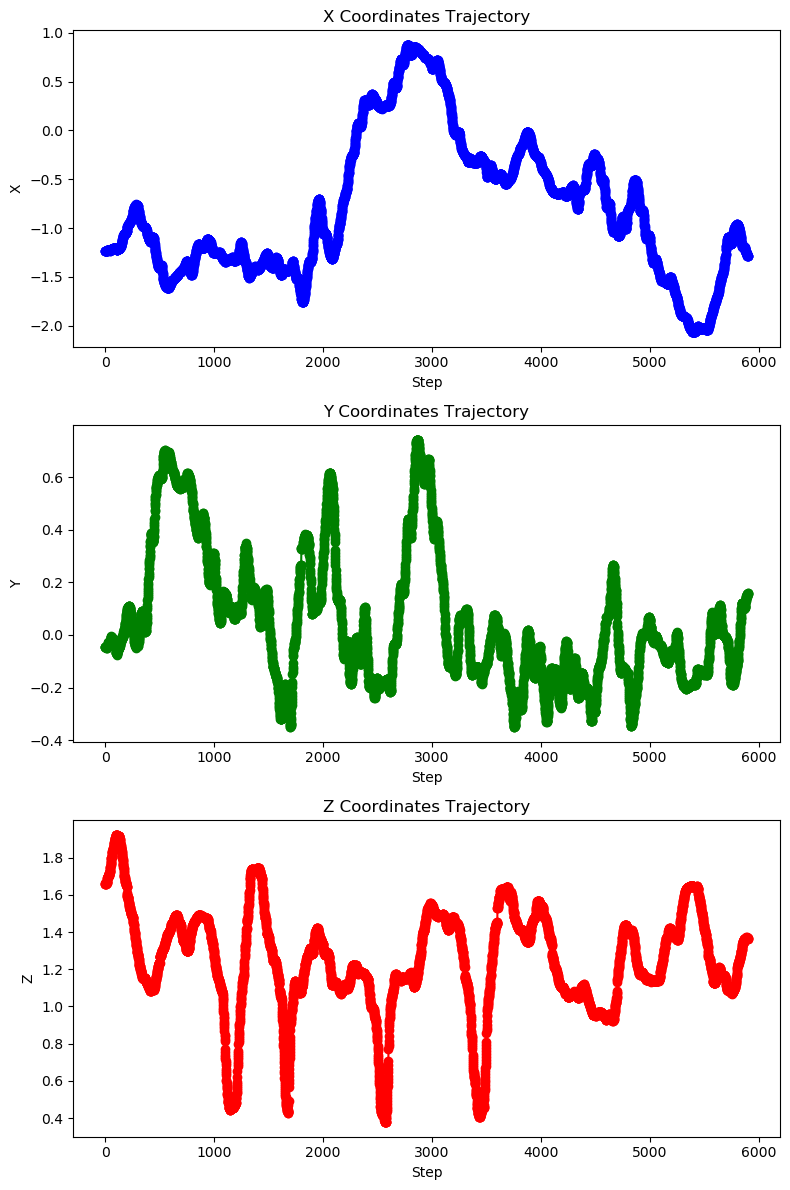

In [12]:
rb = GenerateRosbag()

if v2016:
    bag = rosbag.Bag("/home/josematez/Datasets/scenenn/rosbags/" + "sceneNN_{:03d}_2016".format(scene_id) + ".bag", "w")
else:
    bag = rosbag.Bag("/home/josematez/Datasets/scenenn/rosbags/" + "sceneNN_{:03d}".format(scene_id) + ".bag", "w")

pose_1 = []
pose_2 = []
pose_3 = []

origin, xaxis, yaxis, zaxis = (0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)
Rx = rotation_matrix(np.radians(90), xaxis)
Ry = rotation_matrix(np.radians(90), yaxis)
Rz = rotation_matrix(np.radians(-90), zaxis)

for i in tqdm(range(min(n_data, len(poses)))):
    
    header = Header()
    header.seq = i
    header.stamp.secs = i
    header.stamp.nsecs = 0
    header.frame_id = "camera"

    img_rgb = cv2.imread(dataset_path + "images/image/image{:05d}".format(i+1) + ".png", -1)
    img_depth = cv2.imread(dataset_path + "images/depth/depth{:05d}".format(i+1) + ".png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 1000.
    
    #pose = convert_4x4_matrix_robotics_to_cv(np.array(matrix_list))
    pose = Rx @ poses[i] @ np.linalg.inv(Ry @ Rz)
    #pose = np.linalg.inv(poses[i])

    pose_quat = quaternion_from_matrix(pose)
    pose_t = pose[:3,3].reshape(-1)
    pose = [*pose_quat] + [*pose_t]

    pose_1.append(pose_t[0])
    pose_2.append(pose_t[1])
    pose_3.append(pose_t[2])

    rgb_msg = rb.create_image_msg(img_rgb, deepcopy(header))
    depth_msg = rb.create_image_msg(img_depth, deepcopy(header))
    cam_info_msg = rb.create_camera_info_msg(img_rgb, intrinsics, deepcopy(header))
    pose_msg = rb.create_pose_msg(pose, deepcopy(header))
    #tf_msg = rb.create_tf_msg(pose, deepcopy(header))


    bag.write("camera/rgb", rgb_msg)
    bag.write("camera/depth", depth_msg)
    bag.write("camera/camera_info", cam_info_msg)
    #bag.write("tf", tf_msg)
    bag.write("amcl_pose", pose_msg)

bag.close()


fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot x coordinates trajectory
axs[0].plot(pose_1, marker='o', linestyle='-', color='b')
axs[0].set_title('X Coordinates Trajectory')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('X')

# Plot y coordinates trajectory
axs[1].plot(pose_2, marker='o', linestyle='-', color='g')
axs[1].set_title('Y Coordinates Trajectory')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Y')

# Plot z coordinates trajectory
axs[2].plot(pose_3, marker='o', linestyle='-', color='r')
axs[2].set_title('Z Coordinates Trajectory')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

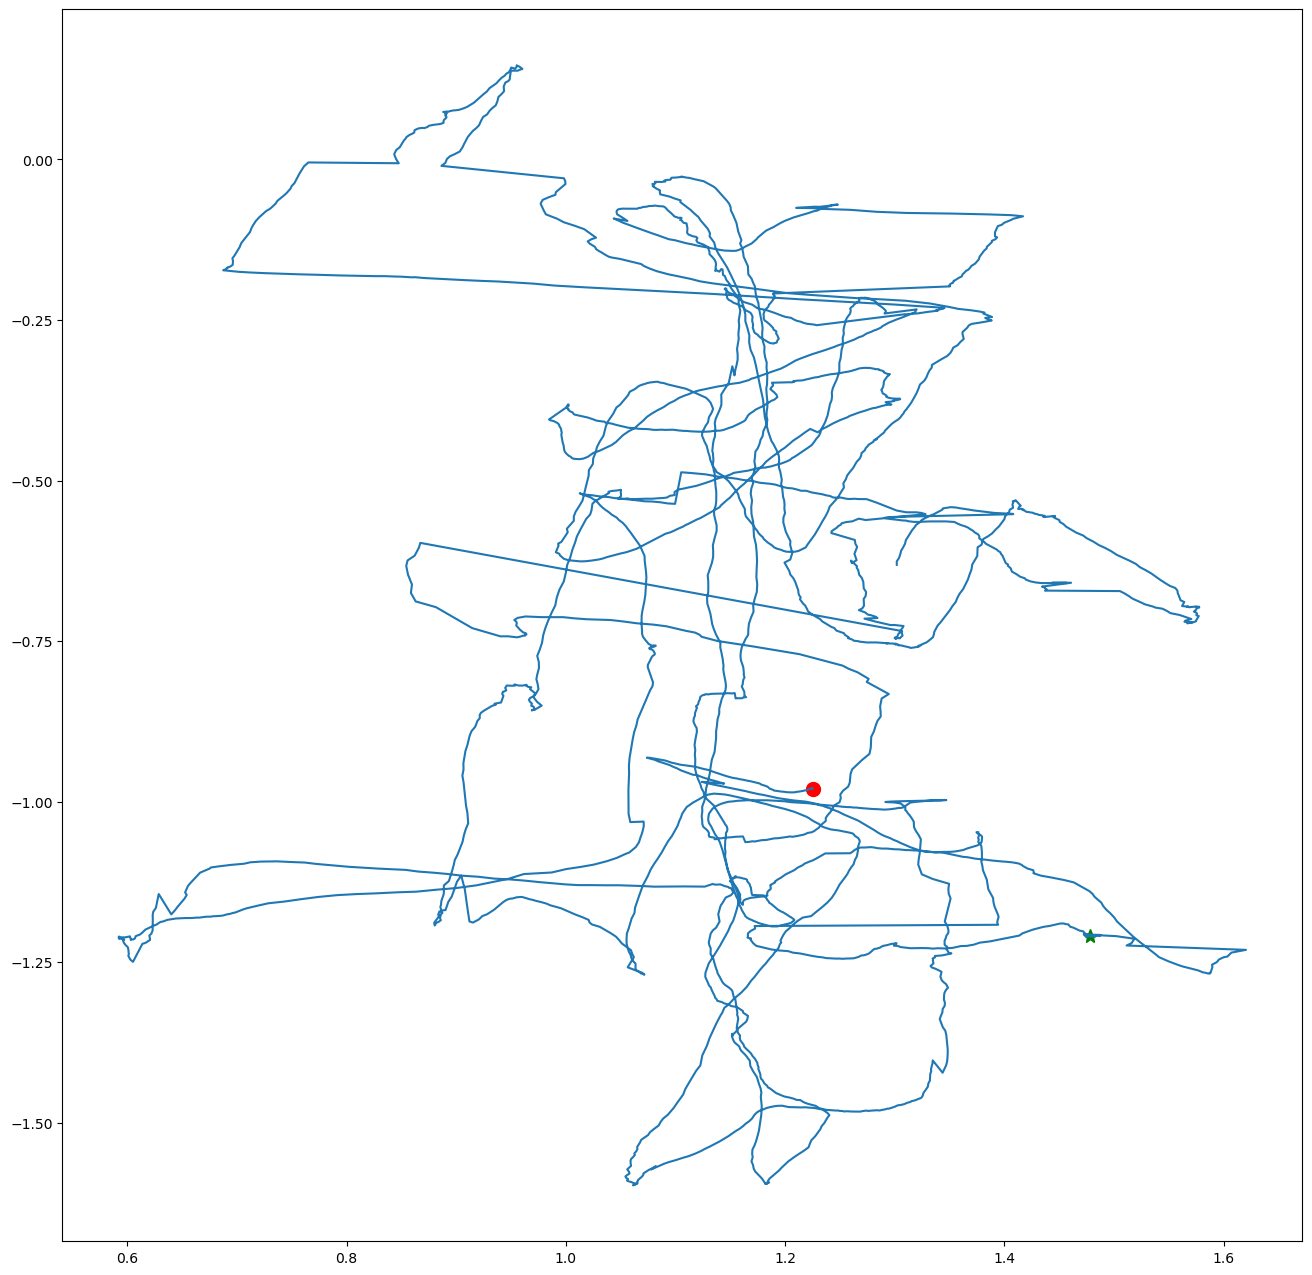

In [32]:
plt.figure(figsize=(16,16))
plt.plot(pose_2[0], -pose_1[0], "ro", markersize=10)
plt.plot(pose_2[288], -pose_1[288], "g*", markersize=10)

plt.plot(pose_2, -np.array(pose_1))

160
128


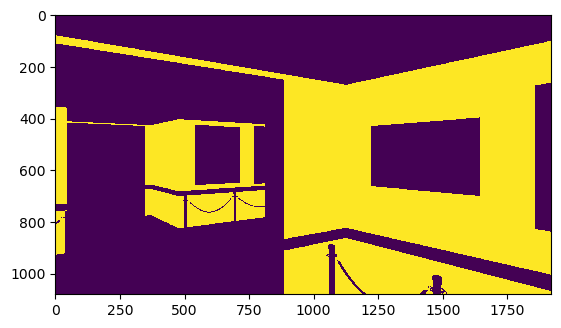

NameError: name 'img_rgb' is not defined

In [8]:
img_seg = cv2.imread(seg_path + "classgt_" + "{0:05d}".format(0) + ".png", -1)

img_seg_bn = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)
print(img_seg_bn[600,1000])


img_seg_bn = cv2.cvtColor(cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2GRAY)
print(img_seg_bn[600,1000])

plt.imshow(img_seg_bn == 128)
plt.show()
plt.imshow(img_rgb)
print(img_seg.shape)

print(img_seg_bn[0,0])

In [5]:
print(tf_msg)

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 0
        nsecs:         0
      frame_id: "base_link"
    child_frame_id: "camera"
    transform: 
      translation: 
        x: 0.0
        y: 0.0
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 0
        nsecs:         0
      frame_id: "map"
    child_frame_id: "base_link"
    transform: 
      translation: 
        x: -2.5515585659689273
        y: 1.903976052088743
        z: 1.6499999999999997
      rotation: 
        x: 2.010366508708899e-17
        y: 0.0
        z: -0.32831776641372745
        w: 0.9445673241700955
